# Regional simulation at Continental US domain using NLDAS2 forcing

In the last tutorial note, we have used the single-point forcing at the Bondville site.

Now we can move on to running a 2D regional simulation with NLDAS2 domain

## 1. Generate geo_em domain file
Usually, the `create_forcing.exe` executable requires a **geo_em** file, providing domain information. This **geo_em** file can be generated from WPS `geogrid.exe` at: https://www2.mmm.ucar.edu/wrf/OnLineTutorial/Basics/index.php


In this tutorial, the domain file for the NLDAS2 forcing is already provided in the GitHub tutorial page, as `geo_em.d01_NLDAS0125.nc`.

We can check on this file:

`ncview geo_em.d01_NLDAS0125.nc` (for example, **HGT_M** variable for terrain height)
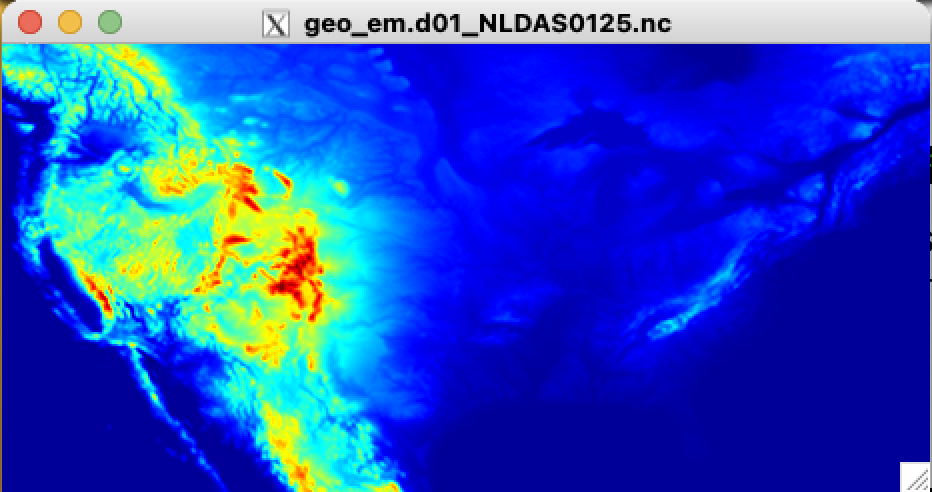



For users interested in other domains in the world, just use the **geogrid.exe** program in WPS to setup a domain file, before generate forcing with **create_forcing.exe**.


## 2. Download NLDAS2 Forcing

Before we start downloading data, it is recommended to create directories for storing the raw and pre-processed data. 

`mkdir NLDAS_forcing`

`mkdir NLDAS_forcing/raw`

`mkdir NLDAS_forcing/extracted`

`cd NLDAS_forcing/raw`

The NLDAS-2 LSM model forcing can be accessed at the NASA Earthdata archive:
https://disc.gsfc.nasa.gov/datasets/NLDAS_FORA0125_H_002/summary?keywords=NLDAS

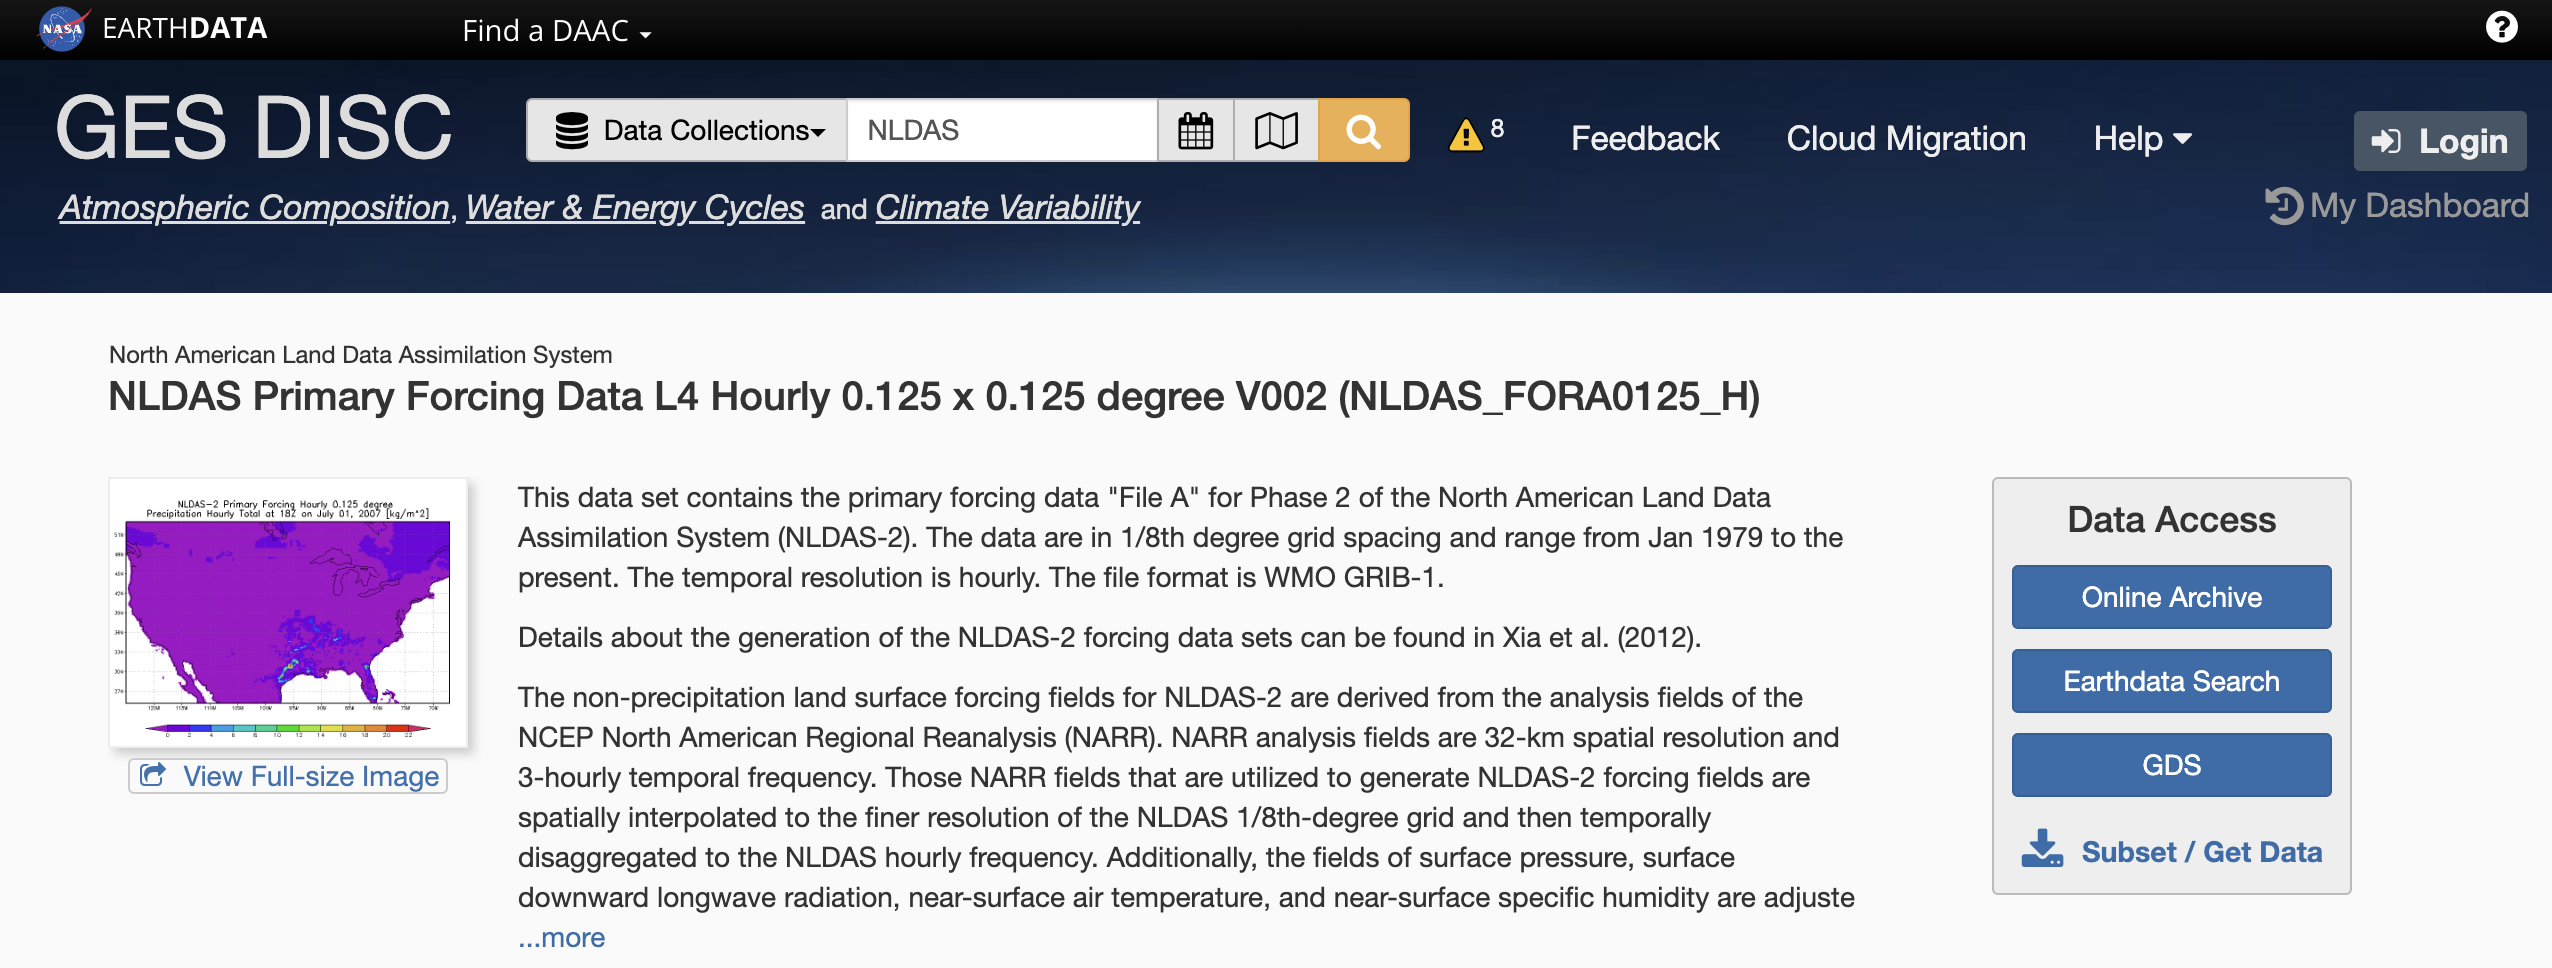

The NLDAS-2 forcing starts from 1979-01-01 to present date, with spatial resolution 0.125 ° x 0.125 ° and hourly temporal interval. in grib format.

In this tutorial, we will show an example of running NLDAS-2 forcing for 3-day. 

Note that you will need to **register** and **log in** before downloading data from the NASA Earthdata archive.
In this tutorial, for example, we can run 3-day simulation with NLDAS2 forcing, from 2000-01-01. So, download three days forcing from the website.

After selecting the data and time period, we can use the **download.sh** script.

`chmod 777 download.sh`

`./download.sh`

After entering your Earthdata username and password, the download will begin. The whole download process for 3-day period takes about 1 min.

## 3. Pre-processing NLDAS forcing data

Now, after downloading the forcing data, we can go the pre-processing step in: 

`cd ./hrldas/HRLDAS_forcing/run/examples/NLDAS/`

You will need **wgrib** library and **perl** program for this step:

### 3.1 Extract individial variables from the NLDAS GRIB files

**extract_nldas.perl** : The current script uses wgrib to extract individual fields from the NLDAS files. It will process entire years or sections of one year. You can change this by modifying the Perl script.

`@yrs = ("00");`

`$day_start = 1;`

`$day_end   = 3;`

`for($julday=$day_start;$julday<=$day_end;$julday++)`

This line controls the start day and end day of pre-processing forcing.

Change these two paths for where raw NLDAS files are located and where separated(extracted) files will go. 

`$data_dir = "/raw_NLDAS_data_path";`

`$results_dir = "/extracted_NLDAS_data_path";`


For convenience, you may want to create directories in the results_dir for each variable and a few more for processed fields:

`cd /extracted_NLDAS_data_path`

`mkdir DLWRF/ DSWRF/ APCP/ PRES/ TMP/ SPFH/ UGRD/ VGRD/ INIT/ FIXED/`

By running the **extract_nldas.perl** code, you can find each extracted variables in above separated directories.

`perl extract_nldas.perl`

`ls -l /extracted_NLDAS_data_path/*`


### 3.2 extract the initial-only fields

**extract_nldas_init.perl**: extract the initial-only fields (TSOIL,SOILM,AVSFT,CNWAT,WEASD) from the NLDAS GRIB output files

Change the date of initialization and run the script one time. The files should appear in the `/extracted_NLDAS_data_path/INIT/` directory.

**Note**: this step is not necessary unless you want to intialize using the NLDAS states. Other alternative way to initialize, you can use WRF model output soil moisture, soil temperautre, SWE too. 

### 3.3 intermediate clean-up (optional)

If you are space-limited, at this point you can remove the raw NLDAS files. You have extracted all you need and they are no longer needed.

### 3.4 Uncompress the NLDAS elevation file for height adjustment of forcing.

this is provided in the `./run/examples/NLDAS/NLDAS_ELEVATION.grb.gz`

`gzip -d NLDAS_ELEVATION.grb.gz`

you can put these wherever, but I leave them here (see the namelist Zfile_template)
  
--------------------------------------------------




### 3.5 Run the HRLDAS pre-processor code.

At this point, you should have all the NARR output extracted into different directories at /extracted_NARR_data_path/. Now it's finally time to run the first step of the HRLDAS.

`cd /root_path/hrldas/hrldas/HRLDAS_forcing/`

In the `examples/NLDAS/` directory there is a `namelist.input.NLDAS` file that is consistent with the NLDAS procedure described above. You can modify this file for your case and place it in the pre-processor run directory:

`cp examples/NLDAS/namelist.input.NLDAS .`

#### 3.5.1 Modify the namelist

Modifying the `namelist.input.NLDAS` to your case. The following is a short description of each line in the file. A longer description is available in `README.namelist`. Modify the `namelist.input.NLDAS` file accordingly to generate forcing.

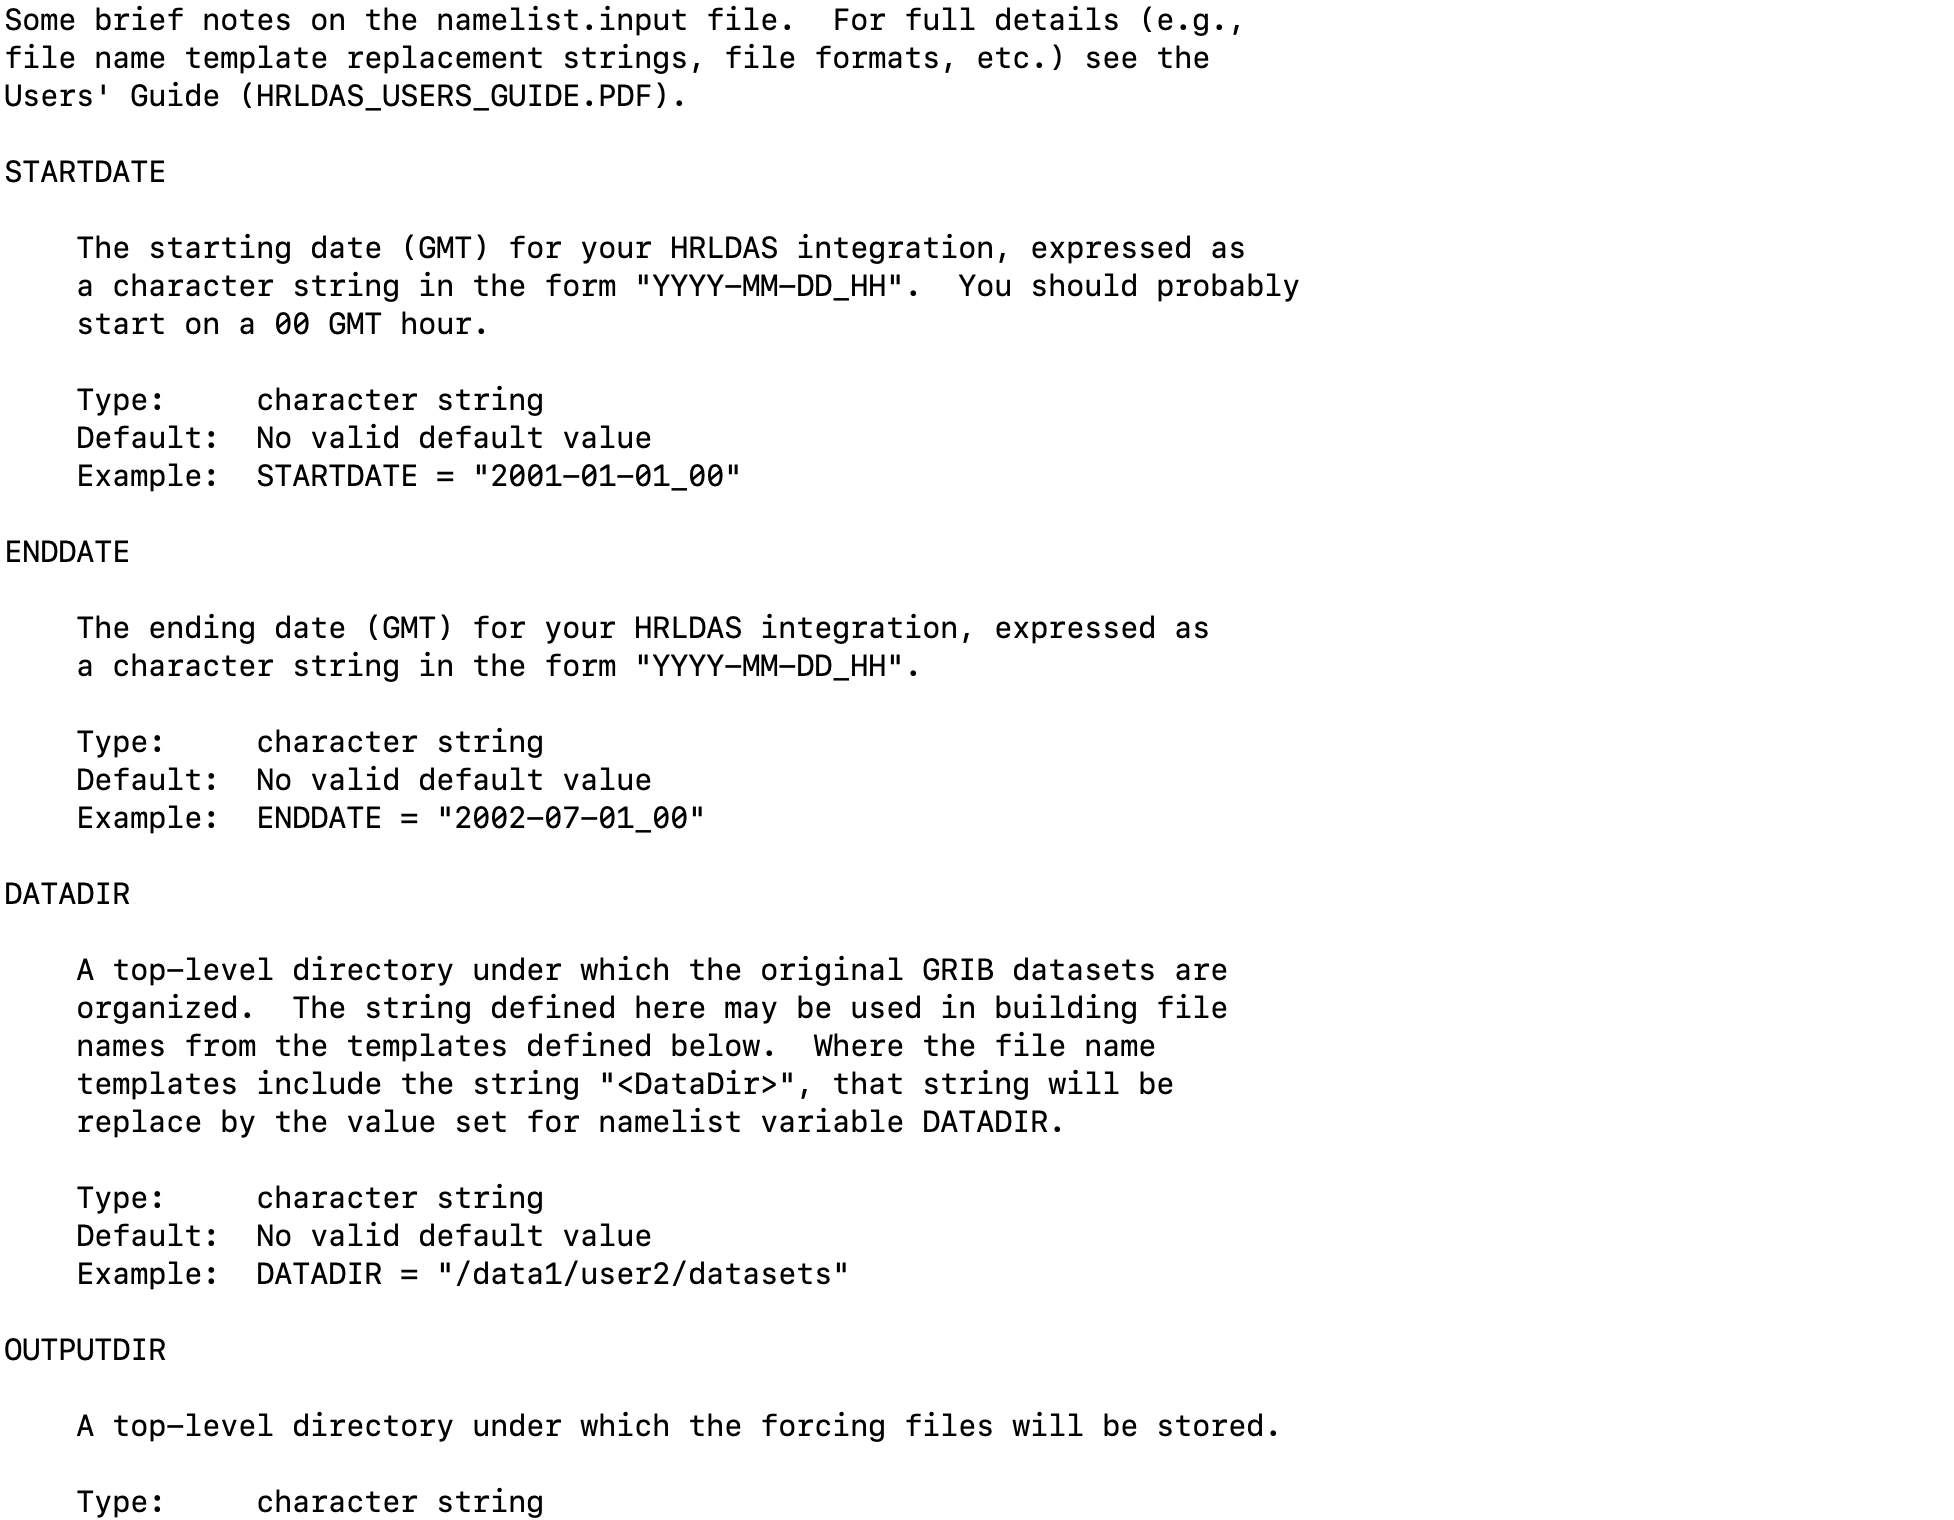
......

**Note**: for NLDAS there will be no need to include a secondary SW and precipitation file, so just set them to be the same

#### 3.5.2 Run the create_forcing.exe

After modifying the namelist for create_forcing.exe, we can now start to generate NLDAS2 forcing data for our 2D domain:

`./create_forcing.exe namelist.input.NLDAS`

Then you can find the forcing data generated in the designated output directory set in the namelist: `OUTPUTDIR`.

`ls LDASIN`

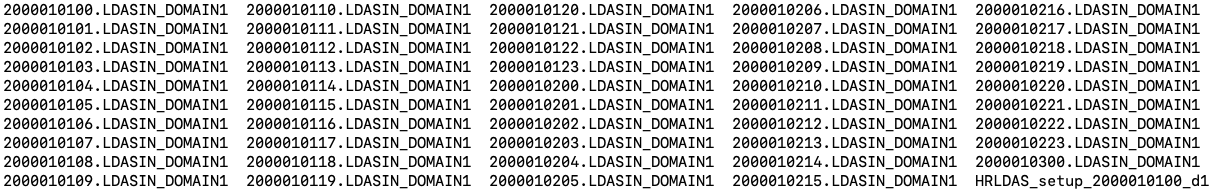

Then if you check the size of the generated forcing, it would be about 167 MB:

`du -h LDASIN/`

`167M    LDASIN/`

## 4. Running CONUS domain with NLDAS2 forcing


### 4.1 Modify namelist
Similar to editing the namelist for single-point simulation, we can now edit the namelist for 2D CONUS simulaiton with NLDAS2 forcing:

 `
 HRLDAS_SETUP_FILE = "../../../NLDAS_forcing/LDASIN/HRLDAS_setup_2000010100_d1"
 INDIR = "../../../NLDAS_forcing/LDASIN/"
 OUTDIR = "../../../NLDAS_forcing/LDASOU/"
 `
 
**Note** remember to change the forcing, model, and output timestep for one hour (3600s):

`
  FORCING_TIMESTEP = 3600
 NOAH_TIMESTEP    = 3600
 OUTPUT_TIMESTEP  = 3600
`

### 4.2 Execute the model
You can either submit the 2D job at login node. Since we only run the model for three day, it wouldn't take so long (about 5-min). 

`./hrldas.exe`

For a larger domain and longer simulation time, it is encouraged to submit jobs to supercomputer, e.g. Cheyenne. We can prepare a job submission script called `runhrldas.csh`

`qsub runhrldas.csh` 


After executing the model run, we can view model runtime printed on the screen: 
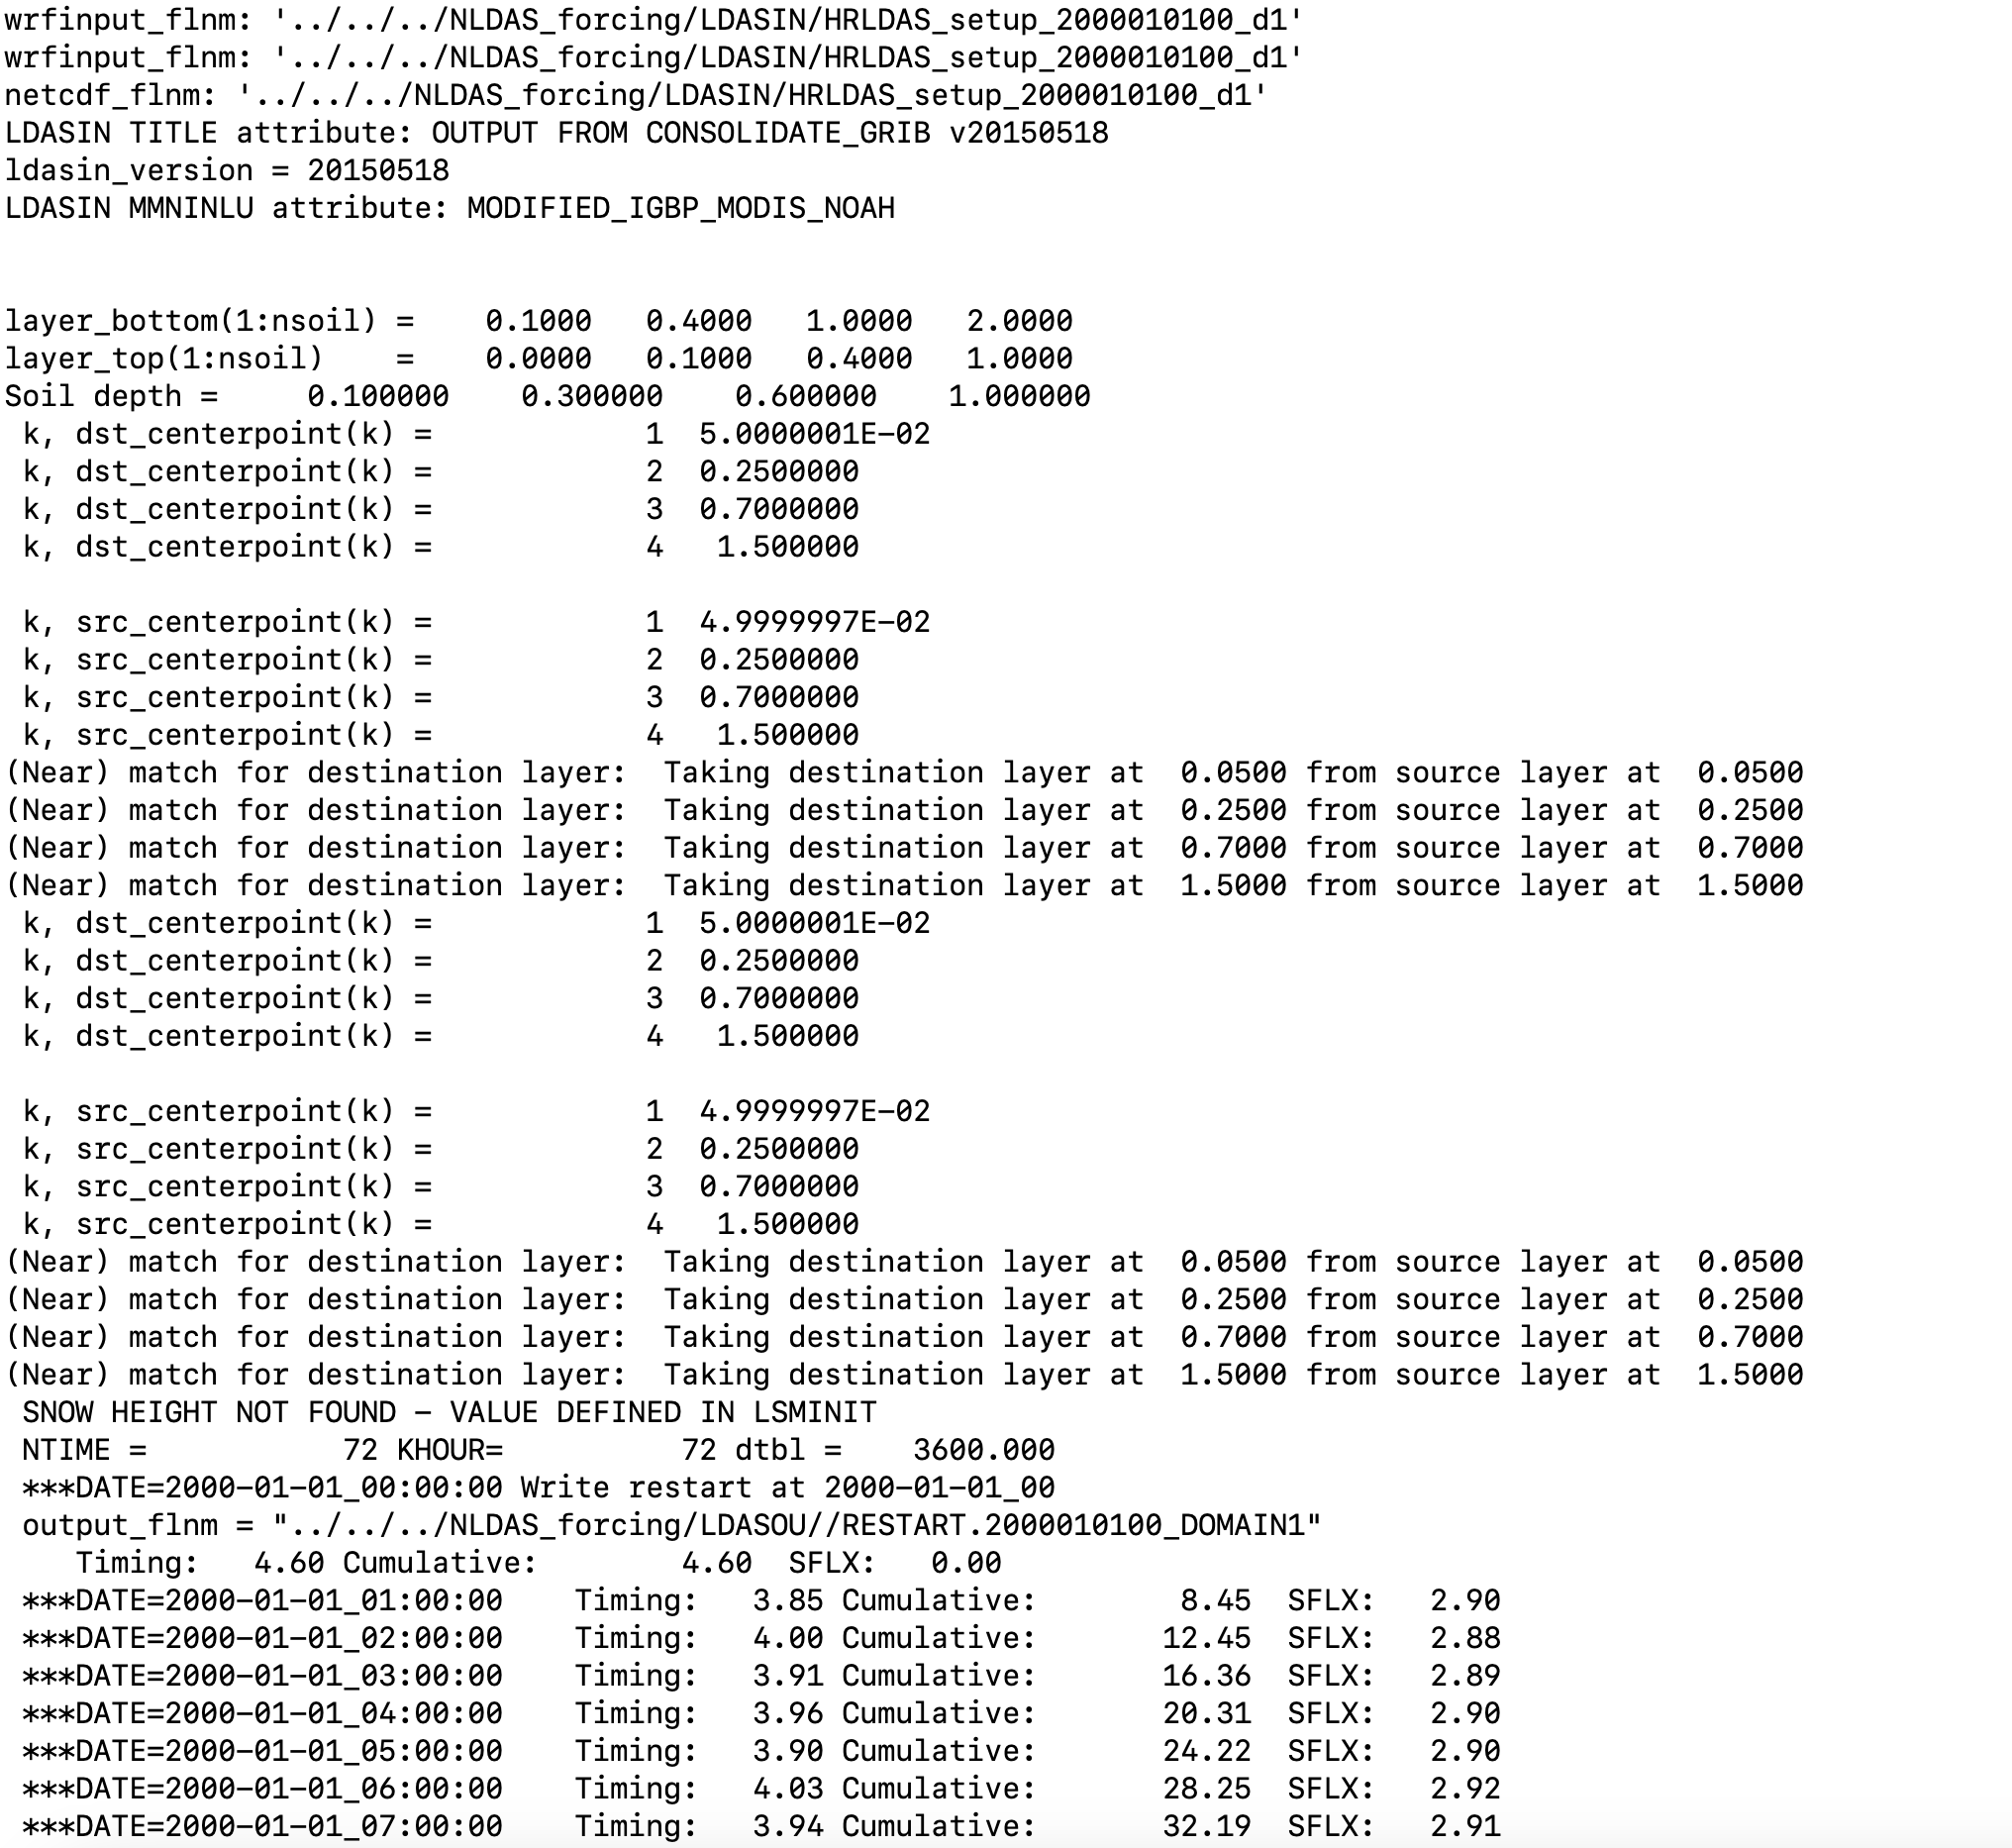
......


### 4.3 Check model outputs
We can quickly view model output using `ncview`:
For the first day results:

`ncview 2000010101.LDASOUT_DOMAIN1`

For example, if we want to view the `LH` hourly results, here is an gif animation:

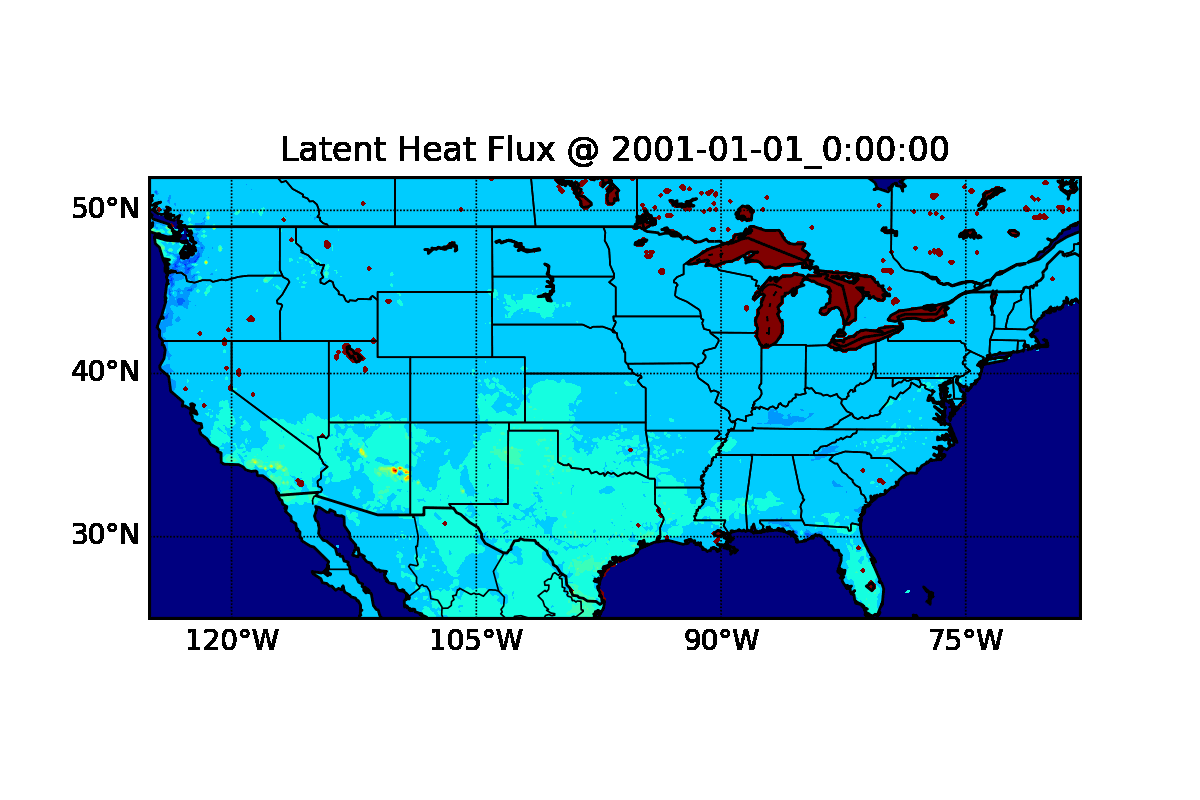

### Congratulations, you have successfully running the 2D CONUS domain simulation!